## 0. Preliminaries


**Importing Necessary Modules**
First, we import the modules that we will be using.  Some modules are imported later on as needed. (Not great python practice, but it will let us talk about new functions as we need them.)

In [ ]:
## Standard Modules for Data Science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Metrics to help evaluate the models
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

**Importing Neural Network Software**  Below, we import the components of the TensorFlow library we need to build this network.


In [ ]:
## TensorFlow/Keras, for building Neural Network Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D


**Mounting the Google Drive**

This assumes you have previously downloaded the data science camp GitHub repository, and are running this notebook from its location in that repository.  Otherwise, you may need to adjust the path to the data as needed.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
## Change the current directory
%cd '/content/gdrive/My Drive/dscamp/dscamp_public/Neural Networks'

/content/gdrive/My Drive/dscamp/dscamp_public/Neural Networks


In [ ]:
## utility Functions for later
def plot_learning_loss(hst):
    """
    Input:
    ---------------
    hst - The training history from a keras model
    
    Returns:
    ---------------
    A figure object with learning curves showing the loss (and accuracy, if available)
    
    """
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    ax.plot(hst.history['loss'], label='Training')
    if 'val_loss' in hst.history.keys():
        ax.plot(hst.history['val_loss'], label='Validation')
        ax.legend()
    ax.set_title('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('loss')
    return fig
    

# 1 Read and Prepare Data

In this Section, we read in the data, both the data about the members of the network, and the images.




## 1.1 Prepare the Response Data

We recover the ages of the individuals from the data set we were working with earlier.


In [ ]:
## Here, we read in the original data.
df = pd.read_csv('data/face_data2.csv', index_col="face_id")

In [ ]:
## Recall the Variables that are included in the data:
df.columns

Index(['age', 'gender', 'relationship', 'music_genre', 'band', 'team',
       'first_name', 'last_name', 'education', 'education_prompt', 'work',
       'work_prompt', 'fav_movie_1', 'fav_movie_2', 'fav_book_1', 'fav_book_2',
       'fav_book_3', 'fav_auth_1', 'fav_auth_2', 'fav_auth_3', 'fav_food_1',
       'fav_food_2', 'fav_food_3', 'home_city', 'home_state', 'languages',
       'hogwarts', 'fav_pet', 'vg_genre', 'fav_video_game', 'spouse_id',
       'n_friends', 'credit', 'gender_female', 'gender_male',
       'relationship_married', 'relationship_single', 'relationship_widowed',
       'music_genre_classical', 'music_genre_country',
       'music_genre_electronic', 'music_genre_folk', 'music_genre_heavy metal',
       'music_genre_hip-hop', 'music_genre_jazz', 'music_genre_rock',
       'music_genre_tibetian throat singing', 'hogwarts_gryffindor',
       'hogwarts_hufflepuff', 'hogwarts_ravenclaw', 'hogwarts_slytherin',
       'fav_pet_birds', 'fav_pet_cats', 'fav_pet_dogs', 'fav_

Since we will be trying to predict the ages of the individuals from their pictures, we should select those values as the response.

In [ ]:
y = df['age'].values

## 1.2 Prepare the Features

Unlike earlier models, the features the model will use to learn and predict ages are the images of the person themselves, rather than other variables.

The images have been stored in a 3-dimensional array, and may be read into memory as shown below.

In [ ]:
## Read in the pictures of each of the individuals
x = np.load('data/faces128_gray.npy')

In [ ]:
x.shape

(1000, 64, 64, 1)

What does each image look like?  To the computer, it looks like this:

In [ ]:
x[0, :, :].reshape(64, 64)

array([[ 90,  96, 103, ...,  84,  82,  78],
       [ 92,  97, 105, ...,  88,  86,  83],
       [ 92,  99, 108, ...,  97,  95,  93],
       ...,
       [173, 168, 164, ..., 124, 122, 108],
       [167, 167, 163, ..., 120, 105, 113],
       [162, 162, 158, ..., 109, 121, 123]], dtype=uint8)

Which is a way of representing this image:

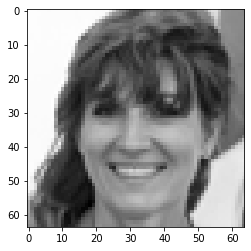

In [ ]:
plt.imshow(x[888, :, :,0], cmap='gray')

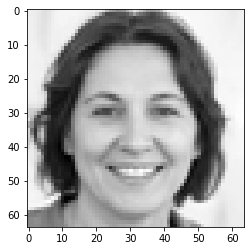

In [ ]:
## To look at another image:
plt.imshow(x[666, :, :,0], cmap='gray')

## 1.3 Separate Data into Train and Test

We can again use the train_test_split function from scikit-learn to separate our data into training and testing sets. 

We continue to use the same seed as before, so our training and testing sets are consistent.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [ ]:
X_train.shape

(800, 64, 64, 1)

## 1.4 Scale the data

Since in this image data, we know that we the intensity of each pixel can be between 0 and 255, we can easily scale the data by dividing by 255.  

This is very similar to MinMax Scaling, 

In [ ]:
X_train = X_train/255
X_test = X_test/255

# 2 Build a Convolutional Neural Network

We are finally ready to build the network model.  Since we are working with images as predictors, we will build the network with 2 dimensional convlutional layers.  These structures are particularly good at representing images.

In [ ]:
model1 = Sequential()
model1.add(Conv2D(20, 8, 8, input_shape=(64, 64, 1), padding='same', activation='relu'))
model1.add(Dropout(0.2))
model1.add(Conv2D(50, 3, 3, activation='relu', padding='same'))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='linear'))

In [ ]:
model1.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
trn_hist = model1.fit(X_train, y_train, batch_size=60, epochs=100, verbose=1, validation_data=(X_test, y_test))



Epoch 1/100
14/14 [==============================] - 1s 18ms/step - loss: 1046.6100 - val_loss: 828.4850
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 501.1891 - val_loss: 262.5437
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 214.5697 - val_loss: 210.4166
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 182.8183 - val_loss: 206.3149
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 175.2587 - val_loss: 197.6996
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 174.6925 - val_loss: 196.7585
Epoch 7/100
14/14 [==============================] - 0s 8ms/step - loss: 171.8219 - val_loss: 192.2355
Epoch 8/100
14/14 [==============================] - 0s 9ms/step - loss: 172.1116 - val_loss: 192.8615
Epoch 9/100
14/14 [==============================] - 0s 8ms/step - loss: 171.6110 - val_loss: 194.4877
Epoch 10/100
14/14 [==============================] - 0s 8ms/step - los

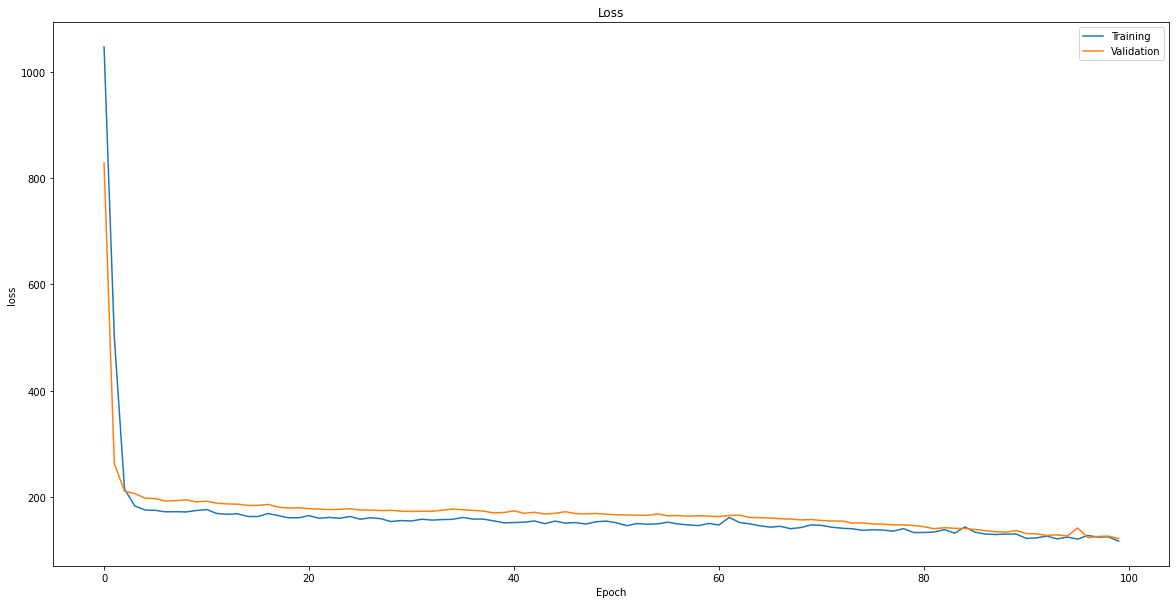

In [ ]:
fig = plot_learning_loss(trn_hist)

In [ ]:
## Model Evaluation

##Predict on the training and test set
yhat_train = model1.predict(X_train)
yhat_test = model1.predict(X_test)



In [ ]:
mean_squared_error(y_train, yhat_train)

105.01799654378064

In [ ]:
mean_squared_error(y_test, yhat_test)

121.61123089108344

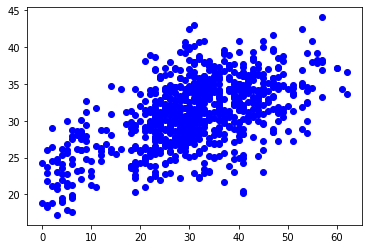

In [ ]:
plt.plot(y_train, yhat_train, 'bo')


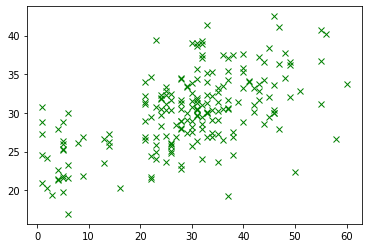

In [ ]:
plt.plot(y_test, yhat_test, 'gx')

**Try a Second Model:** Here we try a different model.  How does it compare?

In [ ]:
model2 = Sequential()
model2.add(Conv2D(20, (5, 5), input_shape=(64, 64, 1), padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(50, (5, 5), activation='relu', padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Flatten())
model2.add(Dense(500, activation='relu'))
model2.add(Dense(1, activation='linear'))

In [ ]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
trn_hist = model2.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_test, y_test))



Epoch 1/50
25/25 [==============================] - 6s 215ms/step - loss: 276.0507 - val_loss: 197.8178
Epoch 2/50
25/25 [==============================] - 5s 207ms/step - loss: 172.7604 - val_loss: 190.5509
Epoch 3/50
25/25 [==============================] - 5s 209ms/step - loss: 160.7348 - val_loss: 186.7108
Epoch 4/50
25/25 [==============================] - 5s 208ms/step - loss: 159.1229 - val_loss: 174.6773
Epoch 5/50
25/25 [==============================] - 5s 208ms/step - loss: 148.1170 - val_loss: 172.0721
Epoch 6/50
25/25 [==============================] - 5s 209ms/step - loss: 141.9600 - val_loss: 179.8351
Epoch 7/50
25/25 [==============================] - 5s 211ms/step - loss: 133.4621 - val_loss: 152.2620
Epoch 8/50
25/25 [==============================] - 5s 213ms/step - loss: 109.8991 - val_loss: 118.4025
Epoch 9/50
25/25 [==============================] - 7s 287ms/step - loss: 96.2991 - val_loss: 104.3938
Epoch 10/50
25/25 [==============================] - 5s 211ms/ste

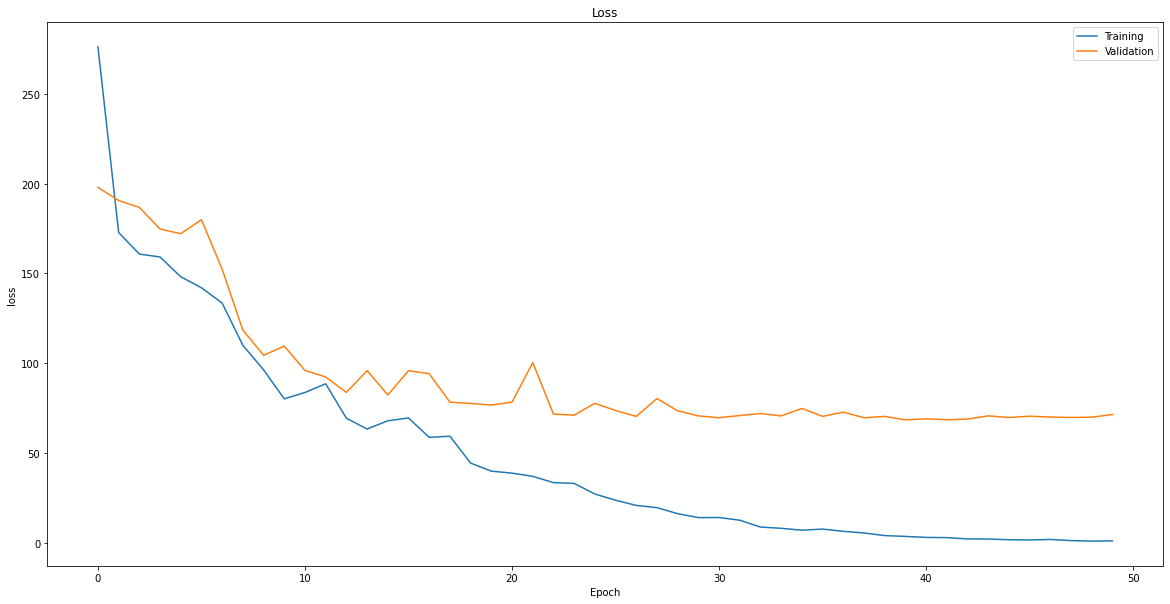

In [ ]:
fig = plot_learning_loss(trn_hist)

In [ ]:
## Model Evaluation

##Predict on the training and test set
yhat_train = model2.predict(X_train)
yhat_test = model2.predict(X_test)



In [ ]:
mean_squared_error(y_train, yhat_train)

0.9016074507652442

In [ ]:
mean_squared_error(y_test, yhat_test)

71.39200811187662

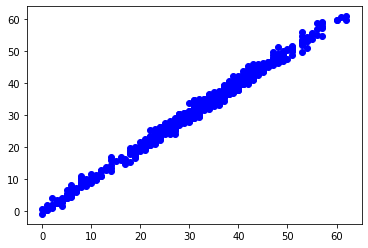

In [ ]:
plt.plot(y_train, yhat_train, 'bo')


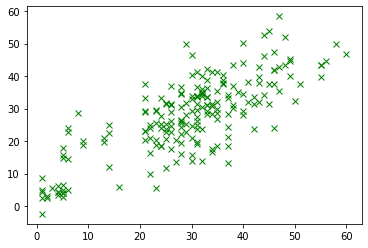

In [ ]:
plt.plot(y_test, yhat_test, 'gx')

# 3 Large, Color CNN

In this portion, we use a larger data set, that has color pictures.

## 3.1 Read In Larger Images

Here we read from a different file, with larger images.

In [ ]:
## Read in the pictures of each of the individuals
x = np.load('data/faces256.npy')

In [ ]:
x.shape

(1000, 128, 128, 3)

What does each image look like?  To the computer, it looks like this:

In [ ]:
x[0, :, :].reshape(128, 128, 3)

array([[[109,  87,  47],
        [113,  89,  50],
        [116,  91,  54],
        ...,
        [103,  77,  44],
        [ 98,  75,  40],
        [ 94,  75,  40]],

       [[111,  87,  49],
        [113,  89,  51],
        [116,  91,  54],
        ...,
        [104,  79,  45],
        [102,  77,  42],
        [ 99,  76,  41]],

       [[111,  88,  49],
        [112,  89,  52],
        [117,  93,  54],
        ...,
        [106,  81,  46],
        [105,  79,  45],
        [103,  77,  45]],

       ...,

       [[151, 172, 179],
        [156, 174, 181],
        [155, 173, 180],
        ...,
        [ 99, 118, 125],
        [105, 124, 131],
        [106, 127, 135]],

       [[150, 170, 176],
        [153, 170, 175],
        [151, 169, 176],
        ...,
        [112, 131, 138],
        [109, 129, 137],
        [107, 127, 134]],

       [[141, 165, 173],
        [145, 164, 171],
        [146, 166, 174],
        ...,
        [114, 133, 141],
        [109, 128, 136],
        [107, 128, 135]]

Which is a way of representing this image:

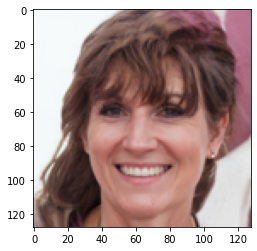

In [ ]:
plt.imshow(x[888, :, :])

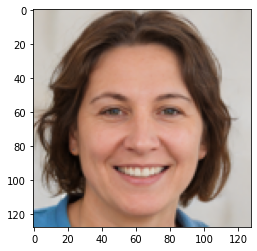

In [ ]:
## To look at the second image:
plt.imshow(x[666, :, :,:])

## 3.2 Process the data

We can again use the train_test_split function from scikit-learn to separate our data into training and testing sets. 

We continue to use the same seed as before, so our training and testing sets are consistent.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [ ]:
X_train.shape

(800, 128, 128, 3)


Since in this image data, we know that we the intensity of each pixel can be between 0 and 255, we can easily scale the data by dividing by 255.  



In [ ]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
model3 = Sequential()
model3.add(Conv2D(20, (5, 5), input_shape=(128, 128, 3), padding='same', activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(Conv2D(50, (5, 5), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(Flatten())
model3.add(Dense(500, activation='relu'))
model3.add(Dense(1, activation='linear'))

In [ ]:
model3.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
trn_hist = model3.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_test, y_test))



Epoch 1/50
25/25 [==============================] - 22s 870ms/step - loss: 223.3809 - val_loss: 182.1917
Epoch 2/50
25/25 [==============================] - 22s 876ms/step - loss: 153.5395 - val_loss: 159.7502
Epoch 3/50
25/25 [==============================] - 22s 864ms/step - loss: 130.6586 - val_loss: 134.2029
Epoch 4/50
25/25 [==============================] - 21s 862ms/step - loss: 97.9368 - val_loss: 97.4644
Epoch 5/50
25/25 [==============================] - 22s 866ms/step - loss: 76.7080 - val_loss: 77.6506
Epoch 6/50
25/25 [==============================] - 22s 866ms/step - loss: 62.2691 - val_loss: 79.2029
Epoch 7/50
25/25 [==============================] - 22s 868ms/step - loss: 49.0036 - val_loss: 73.8933
Epoch 8/50
25/25 [==============================] - 22s 869ms/step - loss: 41.9753 - val_loss: 101.8497
Epoch 9/50
25/25 [==============================] - 22s 867ms/step - loss: 41.8041 - val_loss: 66.0866
Epoch 10/50
25/25 [==============================] - 22s 869ms/ste

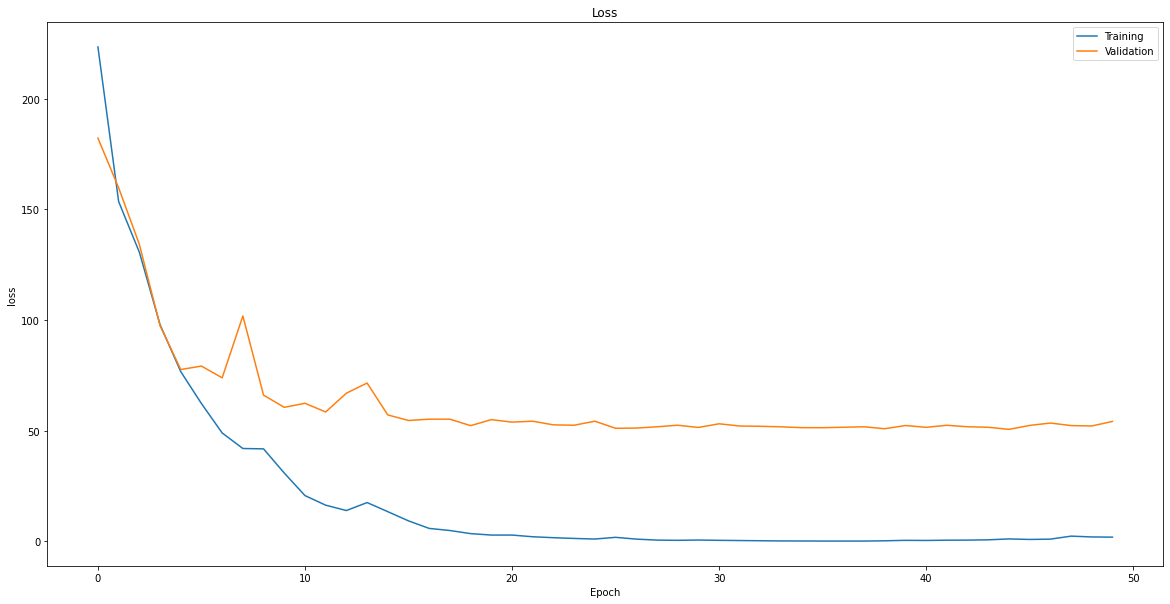

In [ ]:
fig = plot_learning_loss(trn_hist)

In [ ]:
## Model Evaluation

##Predict on the training and test set
yhat_train = model3.predict(X_train)
yhat_test = model3.predict(X_test)



In [ ]:
mean_squared_error(y_train, yhat_train)

1.9725373144861431

In [ ]:
mean_squared_error(y_test, yhat_test)

54.19965871983206

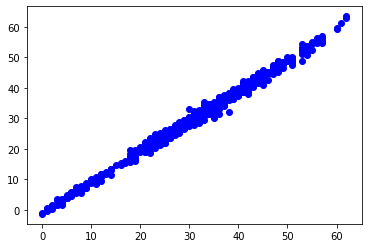

In [ ]:
plt.plot(y_train, yhat_train, 'bo')


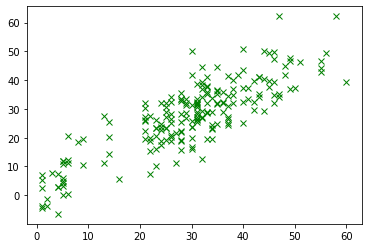

In [ ]:
plt.plot(y_test, yhat_test, 'gx')